In [6]:
import sys
import glob

import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
from iris.experimental.equalise_cubes import equalise_attributes
import numpy as np
import cartopy.crs as ccrs

sys.path.append('/home/599/dbi599/ocean-analysis/modules')
import general_io as gio
import timeseries

## Get file lists

In [51]:
infiles = glob.glob('/g/data/e14/dbi599/CMIP?/CMIP/*/*/piControl/*/Amon/pe/*/*/pe*')
infiles.sort()

## Process data

In [3]:
def regrid(cube):
    """Define the sample points for interpolation"""

    lats = list(np.arange(-89, 90, 2))
    lons = list(np.arange(1, 360, 2))
    
    sample_points = []
    coord_names = [coord.name() for coord in cube.dim_coords]
    if 'time' in coord_names:
        coord_names.remove('time')

    for coord in coord_names:
        if 'lat' in coord:
            sample_points.append((coord, lats))
        elif 'lon' in coord:
            sample_points.append((coord, lons))

    cube = cube.interpolate(sample_points, iris.analysis.Linear())
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
            
    return cube

In [11]:
ensemble_cube_list = iris.cube.CubeList([])
for ensnum, ensemble_member in enumerate(infiles[0:3]):
    print(ensemble_member)
    cube, history = gio.combine_files(ensemble_member, 'precipitation_minus_evaporation_flux')
    cube = gio.check_time_units(cube)
    #cube = cube.extract(time_constraint)
    cube = timeseries.convert_to_annual(cube, aggregation='mean', days_in_month=True)
    cube = cube.collapsed('time', iris.analysis.MEAN)
    cube.remove_coord('time') 
    cube = regrid(cube)
    new_aux_coord = iris.coords.AuxCoord(ensnum, long_name='ensemble_member', units='no_unit')
    cube.add_aux_coord(new_aux_coord)
    cube.cell_methods = ()
    ensemble_cube_list.append(cube)

/g/data/e14/dbi599/CMIP5/CMIP/CCCma/CanESM2/piControl/r1i1p1/Amon/pe/gn/v20120623/pe_Amon_CanESM2_piControl_r1i1p1_gn_201501-301012.nc
/g/data/e14/dbi599/CMIP5/CMIP/CSIRO-QCCCE/CSIRO-Mk3-6-0/piControl/r1i1p1/Amon/pe/gn/v20110518/pe_Amon_CSIRO-Mk3-6-0_piControl_r1i1p1_gn_000101-050012.nc
/g/data/e14/dbi599/CMIP5/CMIP/IPSL/IPSL-CM5A-LR/piControl/r1i1p1/Amon/pe/gn/v20130506/pe_Amon_IPSL-CM5A-LR_piControl_r1i1p1_gn_180001-279912.nc


# Ensemble statistics

Mean and sign agreement.

In [12]:
equalise_attributes(ensemble_cube_list)
ensemble_cube = ensemble_cube_list.merge_cube()

In [13]:
ensemble_cube

<iris 'Cube' of precipitation minus evaporation flux / (kg m-2 s-1) (ensemble_member: 3; latitude: 90; longitude: 180)>

In [31]:
ensemble_mean = ensemble_cube.collapsed('ensemble_member', iris.analysis.MEAN, mdtol=0)
ensemble_mean.remove_coord('ensemble_member')

In [34]:
ensemble_agreement = ensemble_mean.copy()
nmodels = ensemble_cube.shape[0]
pos_data = ensemble_cube.data > 0.0
ensemble_agreement.data = pos_data.sum(axis=0) / nmodels

## Plot

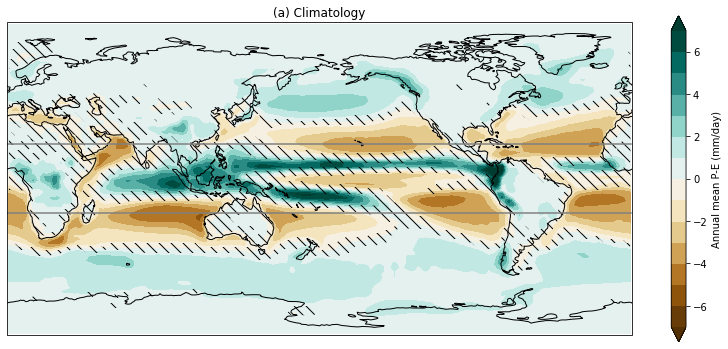

In [54]:
inproj = ccrs.PlateCarree()                  
outproj = ccrs.PlateCarree(central_longitude=180.0)                    

nrows = 1
ncols = 1
fig = plt.figure(figsize=[14, 6])

ax = plt.subplot(nrows, ncols, 1, projection=outproj)
plt.sca(ax)
plt.gca().set_global()
ensmean_data = ensemble_mean.data * 86400
x = ensemble_mean.coord('longitude').points
y = ensemble_mean.coord('latitude').points
cf = ax.contourf(x, y, ensmean_data,
                 transform=inproj,  
                 cmap='BrBG',
                 levels=np.arange(-7, 8, 1),
                 extend='both')
hatch_data = ensemble_agreement.data
ax.contourf(x, y, hatch_data,
            transform=inproj, 
            colors='none',
            levels=(0.1, 0.9),
            hatches=['\\\\'],) # # '.', '/', '\\', '\\\\', '*'
cbar = plt.colorbar(cf)
cbar.set_label('Annual mean P-E (mm/day)')   #, fontsize=label_size)
# cbar.ax.tick_params(labelsize=number_size)
plt.gca().coastlines()
lons = np.arange(-180, 180, 0.5)
lats_sh = np.repeat(-20, len(lons))
lats_nh = np.repeat(20, len(lons))
plt.plot(lons, lats_sh, color='0.5') # linestyle, linewidth
plt.plot(lons, lats_nh, color='0.5')
ax.set_title('(a) Climatology')

plt.show()